# Sentiment Analysis

## Imports

In [2]:
import sys
import os
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import Perceptron

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

ImportError: cannot import name 'Perceptron' from 'sklearn.naive_bayes' (/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/.env/lib/python3.10/site-packages/sklearn/naive_bayes.py)

We need some code that is inside the parent directory of where we are. Inorder for import to work I will add the
parent directory to the system path

In [3]:
os.getcwd()

'/home/hat/dev-env/10Acadamy/week_0/Twitter-Data-Analysis/notebooks'

In [4]:
cwd = os.getcwd()
parent = cwd.replace('/notebooks', '')
sys.path.insert(0, parent) 

In [5]:
from extract_dataframe import read_json
from extract_dataframe import TweetDfExtractor
from clean_tweets_dataframe import CleanTweets
from tweets_preprocess import SADataPreparation
from utils import DataLoader

## Data Preparation

Here, what we have are tweets. I will be considering each tweet as a document.
Let's follow the following steps:
- Read the cached CSV
- Use the `SADataPreparation` class to prepare the data

In [5]:
filename = 'processed_tweet_data.csv'
loader = DataLoader('../', filename)
df = loader.read_csv()
# print(df.shape)
# print(df.columns)
# print(df.info())

(24637, 15)
Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'possibly_sensitive', 'hashtags',
       'user_mentions', 'place'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24637 entries, 0 to 24636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          24637 non-null  object 
 1   source              24633 non-null  object 
 2   original_text       24633 non-null  object 
 3   polarity            24625 non-null  object 
 4   subjectivity        24625 non-null  float64
 5   lang                24625 non-null  object 
 6   favorite_count      24625 non-null  object 
 7   retweet_count       24625 non-null  float64
 8   original_author     24625 non-null  object 
 9   followers_count     24618 non-null  object 
 10  friends_

## Data Cleaner

We have imported the `CleanTweets` class for this task. We will use the `run_pipeline` method to automate the cleaning

In [6]:
cleaner = CleanTweets()
cleaned_df = cleaner.run_pipeline(df, save_csv=True)
# cleaned_df.info()

Automation in Action...!!!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10664 entries, 0 to 10663
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          10664 non-null  datetime64[ns, UTC]
 1   source              10664 non-null  object             
 2   clean_text          10664 non-null  object             
 3   polarity            10664 non-null  float64            
 4   subjectivity        10664 non-null  float64            
 5   lang                10664 non-null  object             
 6   favorite_count      10664 non-null  int64              
 7   retweet_count       10664 non-null  float64            
 8   original_author     10664 non-null  object             
 9   followers_count     10664 non-null  int64              
 10  friends_count       10664 non-null  int64              
 11  possibly_sensitive  10664 non-null  object             
 12  hasht

## Data Preparation

The data needs to be in an X ---> Y format.
The X would be the clean_text and Y would be a label calculated 
from polarity and subjectivity

This is exactly what the `SADataPreparation` class will do for us.


In [7]:
# Get the train test split of the labeled data 
X_train, X_test, y_train, y_test = SADataPreparation().prepare_features(cleaned_df)
len(X_train), len(y_train), len(X_test), len(y_test)

Pre-Processing the Tweets


(9064, 1600, 9064, 1600)

After getting the labled data we will vectorize it in a way a model would understand. Here I will use a Count vector and a Term-Frequnecy Inverse-Document-Frequency of our data and see which is better for the task. I will also be using both a unigram and 

In [8]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(9064, 21385)

In [9]:
count_vect.vocabulary_.get(u'algorithm')

583

In [10]:
# term freq
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(9064, 21385)

In [11]:
# term freq inverse document freq
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(9064, 21385)

In [12]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [13]:
new_docs = ['God is love', 'OpenGL on the GPU is fast', 'I hate killing bugs']
X_new_counts = count_vect.transform(new_docs)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(new_docs, predicted):
    print('%r => %s' % (doc, ["N", "Nu", "P"][category]))

'God is love' => Nu
'OpenGL on the GPU is fast' => Nu
'I hate killing bugs' => P


In [14]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [15]:
import numpy as np
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.689375

In [24]:
from sklearn.linear_model import SGDClassifier, Perceptron
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-4, random_state=4,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.82375

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted,
    target_names={"-1":"N", "0":"Nu", "1":"P"}))

              precision    recall  f1-score   support

          -1       0.82      0.57      0.68       270
           0       0.80      0.93      0.86       742
           1       0.85      0.81      0.83       588

    accuracy                           0.82      1600
   macro avg       0.83      0.77      0.79      1600
weighted avg       0.83      0.82      0.82      1600



In [18]:
metrics.confusion_matrix(y_test, predicted)

array([[155,  75,  40],
       [ 14, 687,  41],
       [ 20,  92, 476]])

In [29]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', Perceptron(penalty='l1'))
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.800625

# Parameter tuning using grid search


In [19]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3, 1e-4),
    'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
}

In [20]:
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [21]:
gs_clf.predict(["The sins of the father are so good will drag the son to hell hate sex"])

array([1])

In [22]:
gs_clf.best_score_

0.8143199896747673

In [23]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0001
clf__loss: 'modified_huber'
tfidf__use_idf: False
vect__ngram_range: (1, 1)


In [34]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [7]:
# Get Vectorized Features
X_train_trigram, X_test_trigram, y_train, y_test, trigram_vect = SADataPreparation().vectorize_features(cleaned_df)

Pre-Processing the Tweets


## Modeling

In [12]:
class Modeling:
    def __init__(self,X_train,X_test,y_train,y_test,trigram_vect):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.trigram_vect = trigram_vect

    def model(self):
        clf = SGDClassifier()#loss="perceptron", eta0=10, learning_rate="constant", penalty=None)#, verbose=3)
        clf.fit(self.X_train, self.y_train)
        
        return clf

    def predict(self, x_test=None):
        sgd_model = self.model()
        if x_test is None:
            
            return sgd_model.predict(self.X_test)
        else:
            x_vect = self.trigram_vect.transform(x_test)
            
            return sgd_model.predict(x_vect)

    def display_model_info(self):
        print(self.model().show_topics(formatted=False))

    def score(self):
        train_score = clf.score(self.predict(self.X_train), self.y_train)
        test_score = clf.score(self.predict(self.X_test), self.y_test)
        print("Train score: "+str(round(train_score, 2))+" ; Validation score: "+str(round(test_score, 2)))

    def precision_recall(self):
        precision = precision_score(self.y_test, self.predict(), average='weighted')
        recall = recall_score(self.y_test, self.predict(), average='weighted')
        print(f'The precision score is {precision} and the recall score is {recall}')

There are lots of missing values in the sensitivity colum, so i will drop it

In [13]:
model_output = Modeling(X_train_trigram,X_test_trigram,y_train, y_test,trigram_vect)
model_output.predict()[:200]

array([ 1,  0,  0,  0,  0, -1,  0,  0,  1,  1,  1,  0, -1,  1,  0,  1,  0,
        0,  1,  0,  0,  1, -1,  1,  0,  0,  0,  0, -1,  0,  1,  0,  1,  0,
        0,  0, -1,  1,  0,  1,  0,  1,  0, -1,  0,  1,  1,  1,  0,  1,  0,
        0, -1,  0,  1, -1,  1,  0,  1,  0,  0,  0,  0, -1,  0,  1,  0,  1,
        1,  0,  1,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0, -1,
        0,  1,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,
       -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  1,
        1,  0,  1,  0,  0,  0, -1,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,
        1,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  1,  0,  1,  0,  1,  1,  0,  1,  1,  0,  0,  0,  1,  0,  1,  0,
        0,  0,  0,  1,  1,  1,  1,  0,  1,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  0,  0,  0,  1,  1, -1,  1,  1,  1,  0,  1])

In [14]:
model_output.predict(["I like this lunch"])

array([0])

In [15]:
model_output.precision_recall()

The precision score is 0.8051081128002368 and the recall score is 0.7918424753867792


Pre-Processing the Tweets


<AxesSubplot:ylabel='score'>

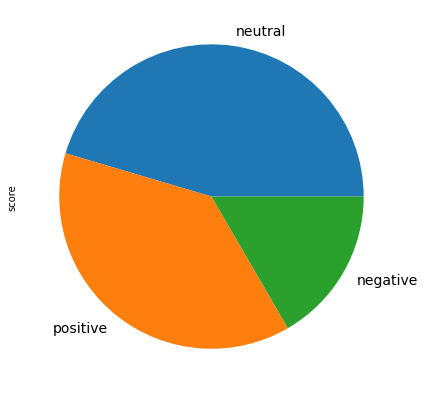

In [33]:
labled_df = SADataPreparation().preprocess_data(cleaned_df, False)
labled_df = labled_df[['clean_text', 'score']]
labled_df['score'].value_counts().plot.pie(figsize=(7,7), fontsize=14)

Next up: Read this blog and use some of the techniques used to find the best parametrs and get the best results.
blog link: https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0